In [54]:
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

Read the predicted annotations and format the data as data frame

In [55]:
start = 15001
end = start + 5000 - 1
pred_fp = f"predictions/frames_zod_detections_{start}_{end}.json"
with open(pred_fp, "r") as file:
    pred_data = json.load(file)

In [56]:
# Create containers for attributes
img_id = []
x1_ls = []
y1_ls = []
x2_ls = []
y2_ls = []
class_ls = []
conf_ls = []
area_ls = []

# Loop through the data and collect attribute values
for key, value in pred_data.items():
    for i in value:
        x1, y1, x2, y2 = i["box"]
        cls = "Vehicle"
        conf = i["confidence"]
        area = i["area"]

        # Append to the corresponding list
        img_id.append(key.split("_")[0])
        x1_ls.append(x1)
        y1_ls.append(y1)
        x2_ls.append(x2)
        y2_ls.append(y2) 
        class_ls.append(cls)
        conf_ls.append(conf)
        area_ls.append(area)

# Rearrange the data into dictionary
new_pred_data = {
    "image_id": img_id,
    "x1": x1_ls,
    "y1": y1_ls,
    "x2": x2_ls,
    "y2": y2_ls,
    "class": class_ls,
    "confidence": conf_ls,
    "area": area_ls
}

# Wrap the new data as a pandas dataframe
pred_df = pd.DataFrame(new_pred_data)

pred_df.head(10)

,image_id,x1,y1,x2,y2,class,confidence,area
0,032353,1935,1108,2024,1183,Vehicle,0.981338,6675
1,032353,2219,1113,2476,1314,Vehicle,0.964930,51657
2,032353,1158,1137,1578,1465,Vehicle,0.960113,137760
3,032353,1685,1113,1825,1237,Vehicle,0.945679,17360
4,032353,2172,1104,2304,1251,Vehicle,0.886827,19404
5,032353,2018,1106,2060,1143,Vehicle,0.869052,1554
6,032353,2379,1087,2931,1462,Vehicle,0.858033,207000
7,032353,1478,1127,1743,1334,Vehicle,0.850088,54855
8,032353,2118,1109,2206,1208,Vehicle,0.844146,8712
9,032353,1761,1098,1867,1214,Vehicle,0.826283,12296


In [57]:
# Save the result to csv
pred_df.to_csv(f"outputs/{start}_{end}/predictions.csv")

Read the ground-truth annotations and format the data as data frame

In [58]:
# Read groud truth data
img_ids = pred_df["image_id"].unique()
true_data = {}
for img_id in img_ids:
    fp = f"single_frames/{img_id}/annotations/object_detection.json"
    with open(fp, "r") as file:
        true_data[img_id] = json.load(file)

In [59]:
# Ground truth attributes needed: coordinates, class, and occolusion ratio
# Create container for attributes
img_id_ls = []
x1_ls = []
y1_ls = []
x2_ls = []
y2_ls = []
class_ls = []
oc_ratio_ls = []

for img_id, img_annots in true_data.items():
    for obj in img_annots:
        px = [p[0] for p in obj["geometry"]["coordinates"]]
        py = [p[1] for p in obj["geometry"]["coordinates"]]
            
        klass = obj["properties"]["class"]
        try:
            oc_ratio = obj["properties"]["occlusion_ratio"]
        except:
            oc_ratio = "Undefined"

        # Append to the corresponding list
        img_id_ls.append(img_id) 
        x1_ls.append(min(px))
        y1_ls.append(min(py))
        x2_ls.append(max(px))
        y2_ls.append(max(py))
        class_ls.append(klass)
        oc_ratio_ls.append(oc_ratio)

    # Rearrange the data into dictionary
    new_true_data = {
        "image_id": img_id_ls,
        "x1": [int(x1) for x1 in x1_ls],
        "y1": [int(y1) for y1 in y1_ls],
        "x2": [int(x2) for x2 in x2_ls],
        "y2": [int(y2) for y2 in y2_ls],
        "class": class_ls,
        "occolusion_ratio": oc_ratio_ls
    }
# Wrap the new data as a pandas dataframe
true_df = pd.DataFrame(new_true_data)

true_df[true_df["class"]=="Vehicle"].head()

,image_id,x1,y1,x2,y2,class,occolusion_ratio
26,032353,2142,1118,2277,1235,Vehicle,Heavy
27,032353,2083,1108,2174,1188,Vehicle,Heavy
28,032353,1487,1102,1677,1224,Vehicle,VeryHeavy
29,032353,1678,1113,1827,1239,Vehicle,Light
30,032353,1792,1115,1887,1188,Vehicle,VeryHeavy


In [60]:
# Save the result to csv
true_df.to_csv(f"outputs/{start}_{end}/ground_truths.csv")

Bounding Box Visualization

In [61]:
def visualize_bboxes(image_path, pred_bboxes, gt_bboxes):
    """
    Visualize prediction and ground truth bounding boxes on an image.
    
    Args:
        image_path (str): Path to the image file.
        pred_bboxes (list of tuples): List of predicted bounding boxes [(x1, y1, x2, y2), ...].
        gt_bboxes (list of tuples): List of ground truth bounding boxes [(x1, y1, x2, y2), ...].
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw prediction boxes in blue
    for (x1, y1, x2, y2) in pred_bboxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue for predictions
        cv2.putText(image, 'Pred', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    # Draw ground truth boxes in green
    for (x1, y1, x2, y2) in gt_bboxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for ground truth
        cv2.putText(image, 'GT', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return image

Calculate KPIs (1) - IoU

In [62]:
def calculate_iou(box1, box2):
    box1 = list(box1)
    box2 = list(box2)
    # Coordinates of intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Compute area of intersection
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Compute areas of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Union area
    union_area = box1_area + box2_area - intersection_area
    
    # IoU calculation
    iou = intersection_area / union_area if union_area != 0 else 0
    return round(iou, 4)

In [63]:
# Test cases
print(calculate_iou([0, 0, 2, 2], [-0.5, -0.5, 1.5, 1.5]))

0.3913


Calculate iou for the selected 5000 predictions

In [64]:
iou_results = {
    "image_id": [],
    "pred_obj": [],
    "true_obj": [],
    "iou": [],
    "occolusion_ratio": [] 
}
for img_id in pred_df["image_id"].unique():
    preds = pred_df[pred_df["image_id"] == img_id]
    truths = true_df[true_df["image_id"] == img_id]

    for pred_idx, pred_obj in preds.iterrows():
        # Maintain a list of IoUs
        iou_ls = []

        # Calculate IoU with all ground truth bounding boxes
        for _, true_obj in truths.iterrows():
            iou = calculate_iou(pred_obj.iloc[1:5], true_obj.iloc[1:5])
            iou_ls.append(iou)
        
        true_idx = np.argmax(iou_ls)

        # Save the result
        iou_results["image_id"].append(img_id)
        iou_results["pred_obj"].append(pred_idx)
        iou_results["true_obj"].append(true_idx)
        iou_results["iou"].append(max(iou_ls))
        iou_results["occolusion_ratio"].append(truths.iloc[true_idx, -1])

iou_results_df = pd.DataFrame(iou_results)
iou_results_df.head()

,image_id,pred_obj,true_obj,iou,occolusion_ratio
0,032353,0,44,0.9421,None
1,032353,1,48,0.7628,Medium
2,032353,2,35,0.7199,Medium
3,032353,3,29,0.9247,Light
4,032353,4,46,0.6571,Heavy


In [65]:
# Save the result to csv
iou_results_df.to_csv(f"outputs/{start}_{end}/kpi/iou.csv")

Summary statistics for the iou results

In [66]:
# Some summary statistics
print("Summary by thresholds: ")
for threshold in np.arange(0, 1, 0.1):
    selector = iou_results_df["iou"] >= threshold
    count = len(iou_results_df[selector])

    print(f"predicted obj with iou >= {threshold:.1f}: {count}")

print("\nSummary by occolusion level:")
for oratio in iou_results_df["occolusion_ratio"].unique():
    selector = (iou_results_df["occolusion_ratio"] == oratio)
    mean = np.mean(iou_results_df[selector]["iou"])

    print(f"mean iou for occlusion ratio {oratio}: {mean:.4f}")

Summary by thresholds: 
predicted obj with iou >= 0.0: 33540
predicted obj with iou >= 0.1: 32936
predicted obj with iou >= 0.2: 32317
predicted obj with iou >= 0.3: 31393
predicted obj with iou >= 0.4: 29893
predicted obj with iou >= 0.5: 27321
predicted obj with iou >= 0.6: 23436
predicted obj with iou >= 0.7: 18731
predicted obj with iou >= 0.8: 13461
predicted obj with iou >= 0.9: 6192

Summary by occolusion level:
mean iou for occlusion ratio None: 0.7925
mean iou for occlusion ratio Medium: 0.6231
mean iou for occlusion ratio Light: 0.7294
mean iou for occlusion ratio Heavy: 0.5492
mean iou for occlusion ratio VeryHeavy: 0.5529
mean iou for occlusion ratio Undefined: 0.3480


Check the results by visualization

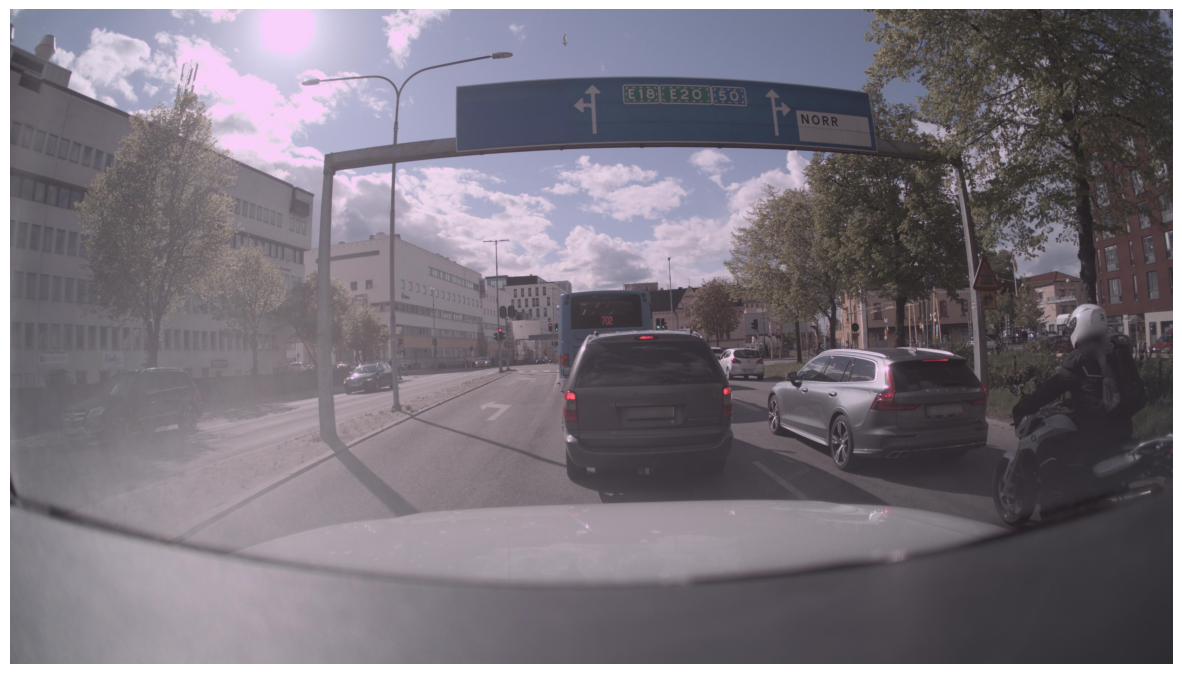

In [67]:
img_id = "012120"

# Search for the image path
directory = f"single_frames_img/{img_id}/camera_front_blur"
img_path = os.path.join(directory, os.listdir(directory)[0])

selector1 = pred_df["image_id"]==img_id
pred_bboxes = pred_df[selector1].iloc[:, 1:5].to_numpy()

selector2 = (true_df["image_id"]==img_id) & (true_df["class"]=="Vehicle")
gt_bboxes = true_df[selector2].iloc[:, 1:5].to_numpy()

bbox_image = visualize_bboxes(img_path, pred_bboxes, gt_bboxes)

plt.figure(figsize=(15, 15))
plt.imshow(bbox_image)
plt.axis('off')
plt.show()

Calculate KPIs (2) - TP, FP, FN, precision and recall

In [ ]:


# Define a function to calculate TP
# TP: prediction = car, truth = Vehicle
def cal_kpi(preds: pd.DataFrame, truths: pd.DataFrame, threshold):
    ''' 
    This function shall be performed for each image.
    The input preds and truths contains the predicted and the ground-truth objects in an image.
    '''
    tp = 0
    fp = 0
    fn = 0
    if_true_detected = np.zeros(len(truths))   # Maintain a list tracking whether a ground-truth object is detected
    
    # Loop through all predicted objects
    for _, pred_obj in preds.iterrows():
        # Maintain a list of IoUs
        iou_ls = []
        
        # Calculate IoU with all ground truth bounding boxes
        for _, true_obj in truths.iterrows():
            iou = calculate_iou(pred_obj[1:5], true_obj[1:5])
            iou_ls.append(iou)
        
        # Find the best match
        idx = np.argmax(iou_ls) # This one is the index of the iou maxima and groud truth
        iou_max = iou_ls[idx]

        # Compare with the threshold
        if iou_max >= threshold:
            # Correct detection
            if truths["class"].iloc[idx] == "Vehicle":
                # Correct classification => TP
                tp += 1
            else:
                # Incorrect classification => FP (for the vechile class)
                fp += 1
            # Update the if_true_detected
            if_true_detected[idx] += 1
        else:
            # Incorrect detection of a vehicle => FP
            fp +=1
        
    # Calculate FN: Vehicles in the ground truth not detected
    selector1 = (if_true_detected == 0) # Select objects in the ground truth not detected
    obj_not_detected = truths[selector1]
    selector2 = (obj_not_detected["class"] == "Vehicle") # Select undetected ground truth objects that are vehicle => FN
    car_not_detected = obj_not_detected[selector2]
    fn = len(car_not_detected)
    
    # # Debugging: check the correctness of tp, fp, fn counts
    # # Rule 1: tp + fp = the number of predicted car
    # print(f"if tp + fp = the number of predicted car: {tp + fp == len(preds)}")
    # # Rule 2: tp + fn = the number of ground truth car
    # print(f"if tp + fp = the number of ground truth car: {tp + fp == len(truths[truths["class"] == "Vehicle"])}")

    # Calculate precision, recall, and accurary
    epsilon = 2E-5
    precision = round(tp / (tp + fp + epsilon), 3)
    recall = round(tp / (tp + fn + epsilon), 3)
    
    return tp, fp, fn, precision, recall

In [69]:
# Get all img_ids
img_ids = pred_df["image_id"].unique()
col_names = ["image_id", "tp", "fp", "fn", "precision", "recall"]
rows = [] 

# Iterate through each img
for img_id in img_ids:
    preds_img = pred_df[pred_df["image_id"]==img_id]
    truths_img = true_df[true_df["image_id"]==img_id]
    tp, fp, fn, precision, recall = cal_kpi(preds_img, truths_img, threshold=0.75)
    # print(f"id: {img_id}, tp: {tp} fp: {fp}, fn: {fn}, precision: {precision}, recall: {recall}")
    rows.append([img_id, tp, fp, fn, precision, recall])

kpi_df = pd.DataFrame(rows, columns=col_names)

kpi_df.head()

,image_id,tp,fp,fn,precision,recall
0,032353,5,10,18,0.333,0.217
1,023247,3,2,22,0.600,0.120
2,005741,7,13,20,0.350,0.259
3,005637,5,7,21,0.417,0.192
4,042080,1,3,21,0.250,0.045


In [70]:
# Save to csv
kpi_df.to_csv(f"outputs/{start}_{end}/kpi/kpi_threshold_0_75.csv")

In [72]:
selector = (kpi_df["precision"] >= 0.5)
print(f"{len(kpi_df[selector])} / {len(kpi_df)}")

selector = (kpi_df["recall"] >= 0.5)
print(f"{len(kpi_df[selector])} / {len(kpi_df)}")

2666 / 4694
224 / 4694


Note:
1. Have a summary of kpis (mean)
2. Add accuracy
3. Check the training data to account for low recall.
4. Set a higher priority on closer (larger box or distance)